In [1]:
import numpy as np
import pandas as pd
import pathlib

data_path = pathlib.Path("./data/")

import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.layouts as bkl
from bokeh.palettes import d3
bkp.output_notebook()

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from scipy.stats import f, t
from scipy.optimize import minimize

from tqdm import tqdm

COLOR = sns.color_palette('deep')

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

# Get data

In [5]:
! rm -rf full_data.csv
! wget https://covid.ourworldindata.org/data/ecdc/full_data.csv
! mv full_data.csv data/ecdc_full_data.csv

--2020-03-21 12:32:17--  https://covid.ourworldindata.org/data/ecdc/full_data.csv
Résolution de covid.ourworldindata.org (covid.ourworldindata.org)… 165.22.65.139, 2a03:b0c0:3:e0::27e:2001
Connexion à covid.ourworldindata.org (covid.ourworldindata.org)|165.22.65.139|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 175554 (171K) [text/csv]
Sauvegarde en : « full_data.csv »

full_data.csv       100%[===================>] 171,44K   623KB/s    ds 0,3s    

2020-03-21 12:32:18 (623 KB/s) — « full_data.csv » sauvegardé [175554/175554]



In [6]:
data = pd.read_csv(data_path / "ecdc_full_data.csv")
data = data.rename(columns={"Total confirmed cases of COVID-19" : "total_cases"})
data['date'] = data.date.apply(pd.to_datetime)
data.head(2)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2019-12-31,Afghanistan,0,0,0,0
1,2020-01-01,Afghanistan,0,0,0,0


In [7]:
def get_country(data: pd.DataFrame, location: str):
    """return the projection of the DataFrame with the selected country"""
    return data[data.location == location]

def get_country_and_min_count(data: pd.DataFrame, location: str, min_count_total=15):
    """return the projection of the DataFrame with the selected country"""
    return data.loc[(data.location == location) & (data.total_cases >= min_count_total) ]

def get_min_count(data: pd.DataFrame, min_count_total=15):
    """return the projection of the DataFrame with the selected country"""
    return data.loc[(data.total_cases >= min_count_total)]

def get_date(data: pd.DataFrame):
    """
    Compute the date corresponding to the Year column
    """
    for location in data.location.unique():
        
        year_column = get_country(data, location=location).Year
        start_date = t + pd.DateOffset(days=year_column.min())
        
        dates = pd.date_range(start=start_date, freq='D', periods=year_column.max() - year_column.min() + 1)
        timestamps[current_line : current_line + dates.shape[0]] = dates
        
        current_line += dates.shape[0] 
        
        data["date"] = timestamps
    

In [44]:
def sigmoid(x, x0, K, a, r):
    """
    Compute the values of a generalized logistic function defined by x0, K, a and r

    Parameters
    ----------
    x0: lag of the generalized logistic function
    K: asymptote of the generalized logistic function
    a: generalized logistic function parameter
    r: generalized logistic function parameter
    
    Return
    ------
    image of x with the generalized logistic function
    """

    return K / (1 + a*np.exp(-r * (x - x0)))

def fit_sigmoid_boostrap(data: pd.DataFrame, n_bootstrap=100, proba=True):
    """
    Compute the optimum parameters to fit a generalized logistic function 
    on the data and estimate the paramters distribution with boostrap
    
    Parameters
    ----------
    data : pd.DataFrame containing the values to fit
    n_bootstrap : Number of boostrap to estimate the distribution of the fitted parameters
    proba : Whether or not to apply linear importance of the most recent values, default=True
    
    Return
    ------
    list of all parameters computed for each boostrap sample
    
    """

    # --- Parameters to be optimized --- #
    params = {"x0": [], "K": [], "a": [], "r": []}
    bootstrap_indexes = []

    # --- data used for the loss --- #
    data = data.reset_index()
    y = data.total_cases 
    t = (data.index.values + 1) 
    
    
    # --- begin bootstrap --- #
    for k in tqdm(range(n_bootstrap), position=0, leave=True):

        rng = np.random.RandomState()
        index_value = data.index.values
        
        # --- sample with a linear probability distribution if proba = True, uniform otherwise --- #
        
        proba = [1/index_value.shape[0] for _ in range(index_value.shape[0])]
        if proba:
            proba = (index_value - np.min(index_value)) / np.sum((index_value - np.min(index_value)))
        
        # --- bootstrap index --- #
        index = rng.choice(y.shape[0], size=y.shape[0], p=proba)
        bootstrap_indexes.append(index)
        
        t_bootstrap = t[index]
        y_bootstrap = y.iloc[index]

        # --- loss function minimise (MSE) with x = (x0, K, a, r) --- #
        fun = lambda x: np.mean((y_bootstrap - sigmoid(t_bootstrap, *x))**2)

        # --- initial parameters --- #
        a0 = np.e
        r0 = 0.1
        x0 = (10, max(y)*1.4, a0, r0)

        # --- optimisation --- #
        res = minimize(fun, x0, method='Nelder-Mead')

        params["x0"].append(res["x"][0])
        params["K"].append(res["x"][1])
        params["a"].append(res["x"][2])
        params["r"].append(res["x"][3])
        
    return params, bootstrap_indexes


def get_prediction_sigmoid(data: pd.DataFrame, fitted_params: dict, n_prediction: int):
    """
    Compute the model predictions with for each quantile 25%, 50% and 75% of the parameter K
    
    Parameters
    ----------
    data : pd.DataFrame containing the values to fit
    fitted_params : list of all parameters computed for each boostrap sample
    n_prediction : Number of data point to predict
    
    Return
    ------
    fitted_sigmoid DataFrame containing all
    """
    quantiles = {
        "25%" : [0.5, 0.25, 0.5, 0.5],
        "50%" : [0.5, 0.5, 0.5, 0.5],
        "75%" : [0.5, 0.75, 0.5, 0.5]
    }

    fitted_sigmoid_df = pd.DataFrame()
    paramters_values_sigmoid = pd.DataFrame()

    t_pred = np.arange(1, n_prediction, 1)    
    t_pred_date = pd.date_range(start=data.date.iloc[0], freq="d", periods=t_pred.shape[0])

    fitted_sigmoid_df["date"] = t_pred_date

    for quantile, quantile_params in quantiles.items():
        # --- get the quantiles of parameters computed via bootstrap ---#
        x0, K, a, r = [np.quantile(list(fitted_params.values())[i], quantile_params[i]) for i in range(len(quantile_params))]

        # --- use the parameters to compute the values of the fitted sigmoid --- #
        fitted_sigmoid_df[quantile] = sigmoid(t_pred, x0, K, a, r)

        # --- keep parameters values of each quantiles --- #
        paramters_values_sigmoid[quantile] = [x0, K, a, r]
        
    return fitted_sigmoid_df, paramters_values_sigmoid
    

def plot_params_distribution(params):
    """
    Plot the parameters distribution
    
    Parameters
    ----------
    params: list of all parameters computed for each boostrap sample

    Return
    ----------
    matplotlib figure 
    """
    param_df = pd.DataFrame(data=params)
    figure = sns.pairplot(param_df, kind='reg', diag_kind='kde', height=3)
    
    return figure

* Compute predictions

In [52]:
df_all_prediction = pd.DataFrame()
countries = ["France", "Italy", 'South Korea', "China"]

for country in countries:
    df = get_country_and_min_count(data, country)

    fitted_params, _ = fit_sigmoid_boostrap(df)

    fitted_sigmoid_df, paramters_values_sigmoid = get_prediction_sigmoid(df, fitted_params, n_prediction=100)
    
    fitted_sigmoid_df["location"] = np.repeat(country, repeats=fitted_sigmoid_df.shape[0])
    df_all_prediction = pd.concat([df_all_prediction, fitted_sigmoid_df])

100%|██████████| 100/100 [00:23<00:00,  4.21it/s]


,date,25%,50%,75%,location
0,2020-02-27,71.413313,74.089913,77.216189,France
1,2020-02-28,91.680986,95.117227,99.130764,France
2,2020-02-29,117.674587,122.085079,127.236544,France
3,2020-03-01,150.994845,156.654193,163.264326,France
4,2020-03-02,193.679072,200.938242,209.416972,France
...,...,...,...,...,...
94,2020-04-03,80861.760347,80985.605146,81059.179353,China
95,2020-04-04,80861.843058,80985.687984,81059.262266,China
96,2020-04-05,80861.909026,80985.754052,81059.328395,China
97,2020-04-06,80861.961639,80985.806746,81059.381137,China


# Plot data

In [56]:
COLORS = d3['Category10'][10]

tooltips = [ ("Nombre de cas", "@total_cases"),
             ("Nouveau cas", "@new_cases"),
             ("Nombre de décés", "@total_deaths"),
             ("Nouveau décés", "@new_deaths"),
             ("Date", "@date{%D}")
           
           ]


tooltips=f"""

    <div>         
        <div>
            <p>
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de cas : </span>
                <span style="font-size: 12px; color: {COLORS[0]}; font-weight: bold;font-family:century gothic;">@total_cases</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de nouveaux cas : </span>
                <span style="font-size: 12px; color: {COLORS[1]}; font-weight: bold;font-family:century gothic;">@new_cases</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre de décés : </span>
                <span style="font-size: 12px; color: {COLORS[3]}; font-weight: bold;font-family:century gothic;">@total_deaths</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Nombre nouveaux décés : </span>
                <span style="font-size: 12px; color: {COLORS[5]}; font-weight: bold;font-family:century gothic;">@new_deaths</span>
            <br> 
                <span style="font-size: 12px; color: black;font-family:century gothic;">Date : </span>
                <span style="font-size: 12px; color: black; font-weight: bold;font-family:century gothic;">""" + """@date{%D}</span>
            </p>
        </div>
    </div>
    """





hover = bkm.tools.HoverTool(names=['line_total'],
    tooltips=tooltips,
    formatters={'@date': 'datetime'},
    mode='vline'
)

# --- define all DataSource needed --- #

source_all = bkm.ColumnDataSource(data)
country = 'France'
source = bkm.ColumnDataSource(get_country(data, country))


source_all_prediction = bkm.ColumnDataSource(df_all_prediction)
source_prediction = bkm.ColumnDataSource(get_country(df_all_prediction, country))

# ----------- # 

p = bkp.figure(y_axis_type="linear", x_axis_type='datetime',
               title=f'Evolution du nombre de cas: {country}', x_axis_label='date', y_axis_label='Number of cases',
               sizing_mode ='stretch_width', tools=[hover, 'pan', 'wheel_zoom', 'reset'], y_range=[-get_country(data, country).total_cases.max()*0.05, 
                                                                                                    get_country(data, country).total_cases.max()*1.1])

p.toolbar.active_scroll = p.select_one(bkm.WheelZoomTool)

p.extra_y_ranges = {"Number of deaths": bkm.Range1d(start=-0.05*get_country(data, country).new_cases.max(), 
                                                    end=1.1*get_country(data, country).new_cases.max()) } 
p.add_layout(bkm.LinearAxis(y_range_name="Number of deaths", axis_label="new_cases"), 'right')


# --- plot total cases --- #

p.line(source=source, x='date', y='total_cases', name='line_total', color=COLORS[0])
p.circle(source=source, x='date', y='total_cases', color=COLORS[0])

# --- plot new cases --- #

p.vbar(source=source, x='date', top='new_cases', color=COLORS[1], width=50e6, alpha=0.5, name='bar', y_range_name="Number of deaths")


# --- plot total death --- #

p.line(source=source, x='date', y='total_deaths', color=COLORS[3], y_range_name="Number of deaths", name='line_death')
p.circle(source=source, x='date', y='total_deaths', color=COLORS[3], y_range_name="Number of deaths")

# --- plot new death --- #

p.vbar(source=source, x='date', top='new_deaths', color=COLORS[5], width=50e6, alpha=0.5, y_range_name="Number of deaths")


button_click_count = bkm.ColumnDataSource({"clicks": [0]})
    
    
select = bkm.Select(title="Country: ", value=country, options=list(data.location.unique()))
button_log = bkm.Button(label="Log Scale", button_type='primary')



# --- Predictions --- #


median_prediction = p.line(source=source_prediction, x='date', y='50%', line_color=COLORS[0])

band_low = bkm.Band(source=source_prediction, base='date', lower='25%', upper='50%', fill_color=COLORS[0],
                level='underlay', fill_alpha=0.1, line_width=0.5, line_color='black')

band_high = bkm.Band(source=source_prediction, base='date', lower='50%', upper='75%', fill_color=COLORS[0],
                level='underlay', fill_alpha=0.1, line_width=0.5, line_color='black')
    
median_prediction.visible=False
band_low.visible=False
band_high.visible=False

p.add_layout(band_low)
p.add_layout(band_high)

button_prediction = bkm.Button(label="Show predictions", button_type="primary")


# -- Callback -- #

callback = bkm.CustomJS(args = dict(source=source, source_all=source_all, select=select, x_range=p.x_range, 
                                    y_range_left=p.y_range, y_range_right=p.extra_y_ranges['Number of deaths'], title=p.title,
                                    button_click_count=button_click_count, source_all_prediction=source_all_prediction, 
                                    source_prediction=source_prediction, median_prediction=median_prediction, band_low=band_low, 
                                    band_high=band_high), code=
            """
            var country = select.value
            
            var date = source_all.data['date']
            var location = source_all.data['location']
            var total_cases = source_all.data['total_cases']
            var new_cases = source_all.data['new_cases']
            var total_deaths = source_all.data['total_deaths']
            var new_deaths = source_all.data['new_deaths']


            var new_date = []
            var new_total_cases = []
            var new_new_cases = []
            var new_total_deaths = []
            var new_new_deaths = []


            for(var i=0; i < date.length; i++){
                if(location[i]==country){
                    new_date.push(date[i]);
                    new_total_cases.push(total_cases[i]);
                    new_new_cases.push(new_cases[i]);
                    new_total_deaths.push(total_deaths[i]);
                    new_new_deaths.push(new_deaths[i]);
                }
            }
            
            source.data['date']=new_date;
            source.data['total_cases']=new_total_cases;
            source.data['new_cases']=new_new_cases;
            source.data['total_deaths']=new_total_deaths;
            source.data['new_deaths']=new_new_deaths;
            
            const new_cases_no_Nan = new_new_cases.filter(function (value) {
                return !Number.isNaN(value);
            });
            const cases_no_Nan = new_total_cases.filter(function (value) {
                return !Number.isNaN(value);
            });
          
            y_range_right.setv({"start": -0.05*Math.max.apply(Math, new_cases_no_Nan), "end": 1.1*Math.max.apply(Math, new_cases_no_Nan)})
            y_range_left.setv({"start": -0.05*Math.max.apply(Math, cases_no_Nan), "end": 1.1*Math.max.apply(Math, cases_no_Nan)})
            
            x_range.setv({"start": -0.05*Math.max.apply(Math, new_date), "end": 1.1*Math.max.apply(Math, new_date)})
            
            title.text = "Evolution du nombre de cas en " + country
            
            source.change.emit();
            
            
            // change value of predictions
            
            button_click_count.data.clicks = 0
            
            median_prediction.visible = false
            band_low.visible = false
            band_high.visible = false
                
            var location = source_all_prediction.data['location']
            var date = source_all_prediction.data['date']
            var quantile_1 = source_all_prediction.data['25%']
            var quantile_2 = source_all_prediction.data['50%']
            var quantile_3 = source_all_prediction.data['75%']

            var new_date = []
            var new_quantile_1 = []
            var new_quantile_2 = []
            var new_quantile_3 = []

            for(var i=0; i < quantile_1.length; i++){
                if(location[i]==country){
                    new_date.push(date[i])
                    new_quantile_1.push(quantile_1[i]);
                    new_quantile_2.push(quantile_2[i]);
                    new_quantile_3.push(quantile_3[i]);
                }
            }   
            
            source_prediction.data['date']=new_date
            source_prediction.data['25%']=new_quantile_1;
            source_prediction.data['50%']=new_quantile_2;
            source_prediction.data['75%']=new_quantile_3;
            
            source_prediction.change.emit();
            
            """)

callback_button = bkm.CustomJS(args = dict(y_axis=p.left, title=p.title), code=
            """
            console.log(y_axis)
            y_axis = LogAxis()
            """)

select.js_on_change('value', callback)
button_log.js_on_click(callback_button)



    
callback_button = bkm.CustomJS(args = dict(source_prediction=source_prediction, source_all_prediction=source_all_prediction, select=select,
                                           button_prediction=button_prediction, median_prediction=median_prediction, band_low=band_low, 
                                           band_high=band_high, button_click_count=button_click_count), code=
        """
        // function to get unique value of an array
        const unique = (value, index, self) => {
            return self.indexOf(value) === index
        }
        
        var country = select.value
        button_click_count.data.clicks ++ 
        var show_prediction = (button_click_count.data.clicks % 2) == 1
        
        var locations_predicted = source_all_prediction.data['location'].filter(unique)
        
        if (locations_predicted.includes(country) == false){
            window.alert("This country doesn't have prediction: Available countries are: " + locations_predicted);
        }
        else{
            if (show_prediction == true){
                median_prediction.visible = true
                band_low.visible = true
                band_high.visible = true
            }
            else{
                median_prediction.visible = false
                band_low.visible = false
                band_high.visible = false
            
            }
        }

        
        """)


button_prediction.js_on_click(callback_button)


bkp.output_file("index.html")

bkp.show(bkm.Column(bkm.Row(select, button_prediction), p, sizing_mode='stretch_width'))

In [54]:
source_prediction.data

{'index': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),
 'date': array(['2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
        '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
        '2020-03-02T00:00:00.000000000', '2020-03-03T00:00:00.000000000',
        '2020-03-04T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
        '2020-03-06T00:00:00.000000000', '2020-03-07T00:00:00.000000000',
        '2020-03-08T00:00:00.000000000', '2020-03-09T00:00:00.000000000',
        '2020-03-10T00:00:00.000000000', '2020-03-11T00:00:00.000000000',
        '2020-03-12

# Predicitons

100%|██████████| 100/100 [00:22<00:00,  4.35it/s]


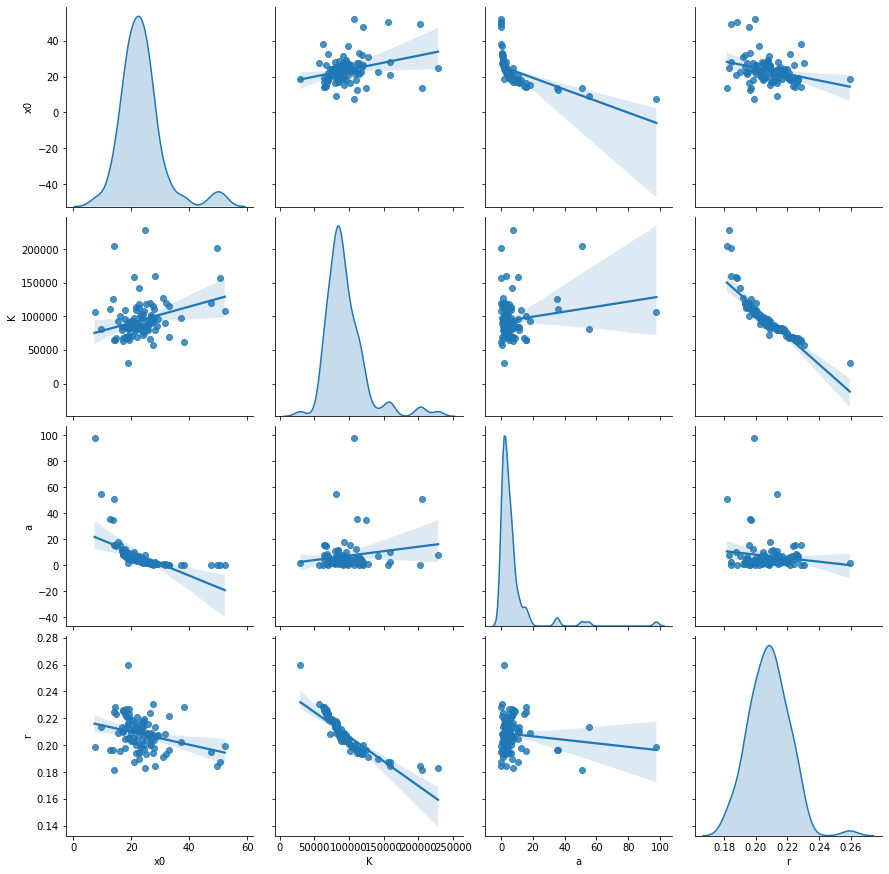

In [386]:
df = get_country_and_min_count(data, "Italy")
fitted_params, bootstrap_indexes = fit_sigmoid_boostrap(df)
plot_params_distribution(params)

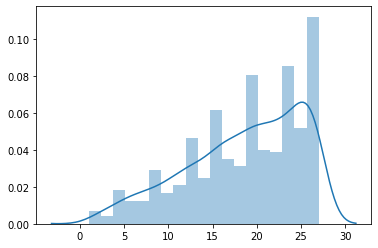

In [387]:
sns.distplot(bootstrap_indexes)

In [383]:
fitted_sigmoid_df, paramters_values_sigmoid = get_prediction_sigmoid(df, fitted_params, 70)

# Bokeh plot prediction

In [20]:
p = bkp.figure(x_axis_type='datetime')

source_prediction = bkm.ColumnDataSource(fitted_sigmoid_df)

p.line(source=source_prediction, x='date', y='50%', line_color=COLORS[0])

band_low = bkm.Band(source=source_prediction, base='date', lower='25%', upper='50%', fill_color=COLORS[0],
                level='underlay', fill_alpha=0.1, line_width=1, line_color='black')

band_high = bkm.Band(source=source_prediction, base='date', lower='50%', upper='75%', fill_color=COLORS[0],
                level='underlay', fill_alpha=0.1, line_width=1, line_color='black')
    
p.add_layout(band_low)
p.add_layout(band_high)

bkp.show(p)

1.0

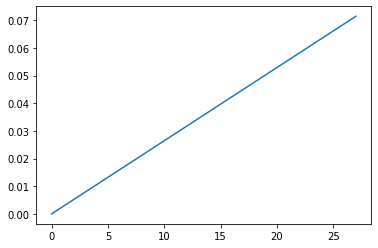

In [382]:
#index = rng.choice(y.shape[0], size=y.shape[0])
index = df.reset_index().index.values
plt.plot(index, (index - np.min(index)) / np.sum((index - np.min(index))))

In [ ]:
df = get_country_and_min_count(data, "Italy")
df[df.date == lockdown["Italy"]]
df = df.reset_index()

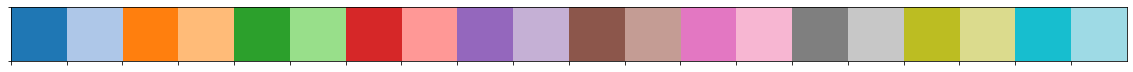

In [127]:
sns.palplot( d3['Category20'][20])

In [228]:
lockdown = {
    "China": pd.Timestamp("23/01/2020"),
    "Italy": pd.Timestamp("23/02/2020"),
    "South Korea": pd.Timestamp("23/02/2020"),
}

inflection = {
    "Italy": pd.Timestamp("16/03/2020"),
}

In [229]:
measure_df = pd.DataFrame({"inflection": inflection, "lockdown": lockdown})
measure_df["Time to inflection"] = measure_df.inflection - measure_df.lockdown
measure_df

,inflection,lockdown,Time to inflection
Italy,2020-03-16,2020-02-23,22 days
China,NaT,2020-01-23,NaT
South Korea,NaT,2020-02-23,NaT


In [230]:
lockdown["China"]

Timestamp('2020-01-23 00:00:00')

In [231]:
df = get_country_and_min_count(data, "Italy")
df[df.date == lockdown["Italy"]]
df = df.reset_index()

{'x_0': 27.06036954800211, 'K': 95705.73570403311, 'a': 1.634451483631502, 'r': 0.20397219452231877}


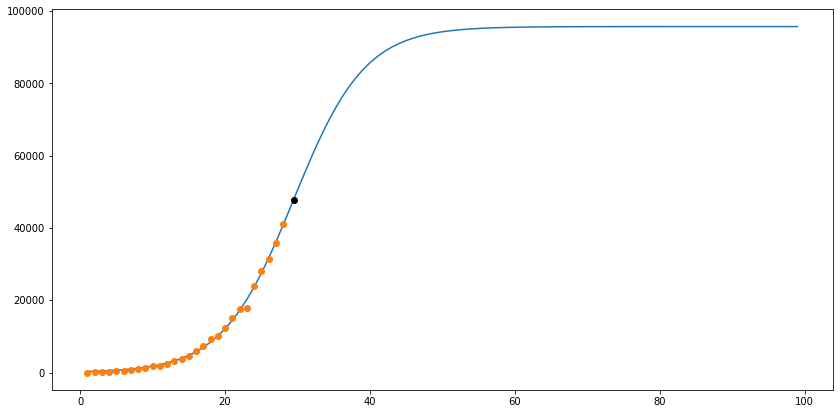

In [232]:
from scipy.optimize import curve_fit

def sigmoid(x, x0, K, a, r):
    return K / (1 + a*np.exp(-r * (x - x0)))

t = df.index.values + 1

p0 = [np.median(t), max(df.total_cases), 1, 0.01] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, t, df.total_cases, p0, method='lm')

parameters_name = ["x_0", "K", "a", "r"]
parameters = {parameters_name[i]: popt[i] for i in range(popt.shape[0])}

plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 100, 1), sigmoid(np.arange(1, 100, 1), *popt))
plt.plot(t, df.total_cases, 'o')
plt.plot(np.log(np.abs(parameters["a"]))/parameters["r"] + parameters["x_0"], parameters["K"]/2, "ok")


print(parameters)
plt.show()

r = 0.28424444157534307
a = 789.9618166868564
r = 0.2775944469194506
a = 822.5801726892665
r = 0.272945569956692
a = 864.3703608883912
r = 0.26945050477507737
a = 910.8345162064269
r = 0.26670395190447344
a = 960.0656911931093
r = 0.2644783519515088
a = 1011.0899195309963
r = 0.26263311356464886
a = 1063.3499464759352
r = 0.2610755540287727
a = 1116.5011027010755
r = 0.25974160084665
a = 1170.3176133651034
r = 0.258585307893162
a = 1224.6448833701395


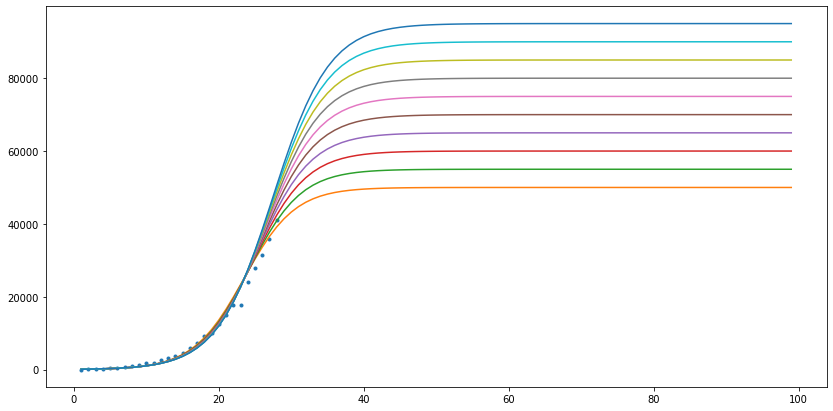

In [233]:
from sklearn.linear_model import LinearRegression as lr

def logit(x):
    return np.log(x/(1-x))

def inv_logit(x):
    return np.exp(x) / (1 + np.exp(x))

    
plt.figure(figsize=(14, 7))
plt.plot(t, df.total_cases, '.')
for K in range(50000, 100000, 5000):
    y = df.total_cases / K
    X = (df.index.values + 1).reshape(-1, 1)

    model = lr()
    model.fit(X, logit(y))

    print(f"r = {model.coef_[0]}")
    print(f"a = {np.exp(-model.intercept_)}")


    t_pred = np.arange(1, 100, 1)
    pred = inv_logit(model.predict(t_pred.reshape(-1, 1))) * K
    plt.plot(t_pred, pred)
plt.show()

In [157]:
from scipy.optimize import minimize

y = df.total_cases 
t = (df.index.values + 1)
t_inflection = 28

# x = (x0, K, a, r)
fun = lambda x: np.mean( (y - sigmoid(t, *x))**2)
#fun = lambda x: np.mean( np.abs((y - sigmoid(t, *x))))

#cons = ({'type': 'eq', 'fun': lambda x : np.log(x[2]) / x[3] + x[0] - t_inflection})

#bnds = ((1, None), (max(y)*1.4, None), (0.01, None), (0.0001, None))

a0 = np.e
r0 = 0.1

x0 = (t_inflection - 10*np.e, max(y)*1.4, a0, r0)
#res = minimize(fun, x0, method='Nelder-Mead', bounds=bnds, constraints=cons)
res = minimize(fun, x0, method='Nelder-Mead')
res

 final_simplex: (array([[2.66271243e+01, 9.57061118e+04, 1.78547412e+00, 2.03971916e-01],
       [2.66271243e+01, 9.57061119e+04, 1.78547412e+00, 2.03971916e-01],
       [2.66271243e+01, 9.57061119e+04, 1.78547412e+00, 2.03971916e-01],
       [2.66271243e+01, 9.57061119e+04, 1.78547412e+00, 2.03971916e-01],
       [2.66271243e+01, 9.57061119e+04, 1.78547412e+00, 2.03971916e-01]]), array([328730.17923648, 328730.17923648, 328730.17923648, 328730.17923648,
       328730.17923648]))
           fun: 328730.1792364801
       message: 'Optimization terminated successfully.'
          nfev: 637
           nit: 361
        status: 0
       success: True
             x: array([2.66271243e+01, 9.57061118e+04, 1.78547412e+00, 2.03971916e-01])

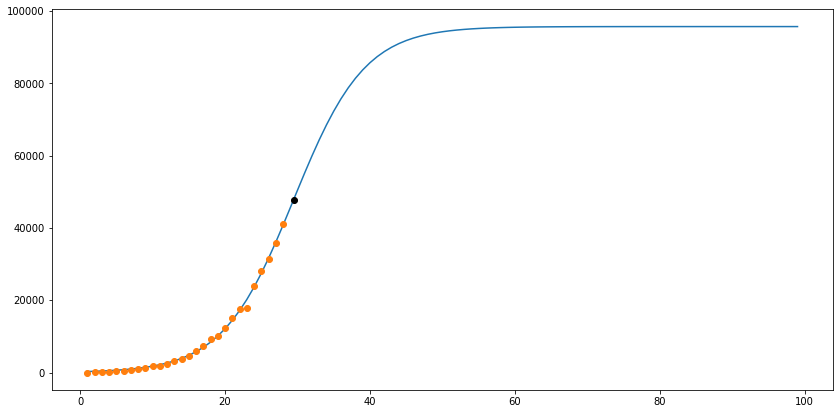

In [158]:
plt.figure(figsize=(14, 7))

popt = res["x"]
plt.plot(np.arange(1, 100, 1), sigmoid(np.arange(1, 100, 1), *popt))
plt.plot(t, df.total_cases, 'o')
plt.plot(np.log(np.abs(parameters["a"]))/parameters["r"] + parameters["x_0"], parameters["K"]/2, "ok")

In [180]:
df = get_country(data, "France")
df = df.reset_index()

{'x_0': 42.65777490041405, 'K': 15330.28118449661, 'a': 27.43498062959732, 'r': 0.2911078372431203}


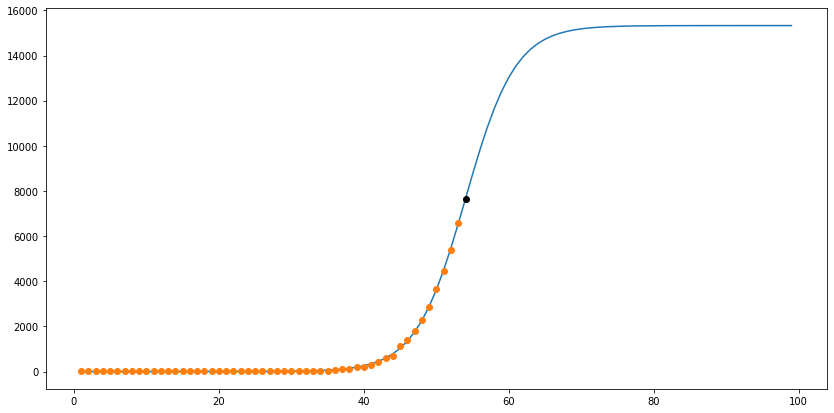

In [185]:
t = df.index.values + 1

p0 = [np.median(t), max(df.total_cases), 1, 0.01] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, t, df.total_cases, p0, method='trf')

parameters_name = ["x_0", "K", "a", "r"]
parameters = {parameters_name[i]: popt[i] for i in range(popt.shape[0])}

plt.figure(figsize=(14, 7))
plt.plot(np.arange(1, 100, 1), sigmoid(np.arange(1, 100, 1), *popt))
plt.plot(t, df.total_cases, 'o')
plt.plot(np.log(np.abs(parameters["a"]))/parameters["r"] + parameters["x_0"], parameters["K"]/2, "ok")


print(parameters)
plt.show()

In [8]:
get_country(data, 'France')

,date,location,new_cases,new_deaths,total_cases,total_deaths
818,2020-01-25,France,NaN,NaN,3,NaN
819,2020-01-26,France,0.0,NaN,3,NaN
820,2020-01-27,France,0.0,NaN,3,NaN
821,2020-01-28,France,0.0,NaN,3,NaN
822,2020-01-29,France,1.0,NaN,4,NaN
823,2020-01-30,France,1.0,NaN,5,NaN
824,2020-01-31,France,1.0,NaN,6,NaN
825,2020-02-01,France,0.0,NaN,6,NaN
826,2020-02-02,France,0.0,NaN,6,NaN
827,2020-02-03,France,0.0,NaN,6,NaN
